In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/content/drive/MyDrive/heart_disease_health_indicators/heart.csv")

In [5]:
model = []

In [71]:
# separar la informacion de las caracteristicas de los datos (x) y la variable objetivo (y)
target='output'

X = df.drop(target, axis = 1)
y = df[target]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# split data

In [141]:
# Split the data into training and testing sets
n = len(X)
valid = (X[:int(0.3*n)+1],y[:int(0.3*n)+1]) # saparamos nuestros datos para validación

#separamos nuestros datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X[:int(0.7*n)], y[:int(0.7*n)], test_size = 0.3, random_state = 42)
X_train

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
124,39,0,2,94,199,0,1,179,0,0.0,2,0,2
72,29,1,1,130,204,0,0,202,0,0.0,2,0,2
15,50,0,2,120,219,0,1,158,0,1.6,1,0,2
10,54,1,0,140,239,0,1,160,0,1.2,2,0,2
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,50,1,2,140,233,0,1,163,0,0.6,1,1,3
71,51,1,2,94,227,0,1,154,1,0.0,2,1,3
106,69,1,3,160,234,1,0,131,0,0.1,1,1,2
270,46,1,0,120,249,0,0,144,0,0.8,2,0,3


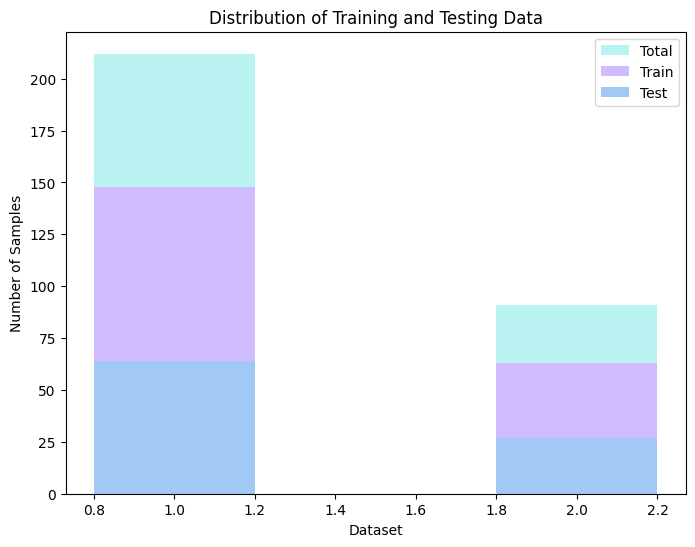

In [ ]:
# Definir tamaño entrenamiento
total_size = int(len(X)*0.7)
train_size = len(X_train)
test_size = len(X_test)

#definir tamaño validacion
valid_size = len(valid[0])
train_size_valid = int(len(valid[0])*0.7)
test_size_valid = int(len(valid[0])*0.3)

# Crear la gráfica apilada
fig, ax = plt.subplots(figsize=(8, 6))

# Valores para la gráfica
train_bars = [train_size, train_size_valid]
test_bars = [test_size, test_size_valid]
total_bars = [total_size, valid_size]

colors = sns.color_palette("pastel")

for i in range(2):

  ax.legend()
  # Gráfico de barras apiladas
  ax.bar(i+1, total_bars[i], color = colors[9], label='Total', width=0.4)
  ax.bar(i+1, train_bars[i], color = colors[4], label='Train', width=0.4)
  ax.bar(i+1, test_bars[i], color = colors[0], label='Test', width=0.4)

  # Añadir etiquetas
  ax.set_xlabel('Dataset')
  ax.set_ylabel('Number of Samples')
  ax.set_title('Distribution of Training and Testing Data')

  # Ajustar el estilo para que se vea mejor
  #ax.set_xticks([i+1])
  #ax.set_xticklabels([f"{i+1}"])

# Mostrar la gráfica
plt.show()

# Usando Todas las características

# usando importance de rf

In [73]:
# tratamiento de datos faltantes (si hay)
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test),columns=X.columns)

In [74]:
# Devuelve las variables binarias
binary_vars = [col for col in df.columns if df[col].nunique() == 2]

# Devuelve las variables categoricas
categorical_vars = [col for col in df.columns if (df[col].nunique() < 11 and col not in binary_vars)]

# devuelve las columnas que no estan escaladas (excluyendo las binarias y categoricas)
cols2scale = [col for col in df.columns if col not in binary_vars + categorical_vars]

# Escalado de caracteristicas
scaler = RobustScaler()
X_train[cols2scale] = scaler.fit_transform(X_train[cols2scale])
X_test[cols2scale] = scaler.transform(X_test[cols2scale])

In [44]:
#usando RF obtenemos las mejores caracteristicas, aun usando todas
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rfc.feature_importances_})

top_features = importance_df.sort_values(by='Importance', ascending=False).head(14)
print(top_features)
X_train=X_train[top_features['Feature']]
X_test=X_test[top_features['Feature']]

     Feature  Importance
9    oldpeak    0.154751
12     thall    0.124284
2         cp    0.119302
7   thalachh    0.110617
11       caa    0.107291
0        age    0.086428
4       chol    0.073123
8       exng    0.063940
3     trtbps    0.059306
1        sex    0.035273
10       slp    0.034932
6    restecg    0.021596
5        fbs    0.009156


In [45]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP Neural Network': MLPClassifier(random_state=42,max_iter=4000)
}

accuracies={} # Dictionary to store accuracies
for name, model in models.items():
    print(f"\n\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy # Stored under the model's name
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

# Convert the accuracies dictionary to a DataFrame
accuracies_df_1 = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])



Training Logistic Regression...
Logistic Regression Accuracy: 0.828125
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.87      0.92      0.89        49

    accuracy                           0.83        64
   macro avg       0.77      0.73      0.74        64
weighted avg       0.82      0.83      0.82        64



Training Decision Tree...
Decision Tree Accuracy: 0.734375
              precision    recall  f1-score   support

           0       0.42      0.33      0.37        15
           1       0.81      0.86      0.83        49

    accuracy                           0.73        64
   macro avg       0.61      0.60      0.60        64
weighted avg       0.72      0.73      0.72        64



Training Random Forest...
Random Forest Accuracy: 0.84375
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1       0.85      0.96      0.90

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.90625
              precision    recall  f1-score   support

           0       0.91      0.67      0.77        15
           1       0.91      0.98      0.94        49

    accuracy                           0.91        64
   macro avg       0.91      0.82      0.86        64
weighted avg       0.91      0.91      0.90        64



Training Naive Bayes...
Naive Bayes Accuracy: 0.8125
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        15
           1       0.88      0.88      0.88        49

    accuracy                           0.81        64
   macro avg       0.74      0.74      0.74        64
weighted avg       0.81      0.81      0.81        64



Training MLP Neural Network...
MLP Neural Network Accuracy: 0.84375
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.88      0.92      0.90        49

    accuracy                  

# Usando el top 7 de las caracteristicas

# importance

In [56]:
#usando RF obtenemos las mejores caracteristicas, aun usando todas
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rfc.feature_importances_})

top_features = importance_df.sort_values(by='Importance', ascending=False).head(14)
print(top_features)
X_train=X_train[top_features['Feature'][:7]]
X_test=X_test[top_features['Feature'][:7]]

     Feature  Importance
9    oldpeak    0.154751
12     thall    0.124284
2         cp    0.119302
7   thalachh    0.110617
11       caa    0.107291
0        age    0.086428
4       chol    0.073123
8       exng    0.063940
3     trtbps    0.059306
1        sex    0.035273
10       slp    0.034932
6    restecg    0.021596
5        fbs    0.009156


In [57]:
models = {
    'Logistic Regression top 7': LogisticRegression(random_state=42),
    'Decision Tree top 7': DecisionTreeClassifier(random_state=42),
    'Random Forest top 7': RandomForestClassifier(random_state=42),
    'SVM top 7': SVC(random_state=42),
    'KNN top 7': KNeighborsClassifier(),
    'Gradient Boosting top 7': GradientBoostingClassifier(random_state=42),
    'XGBoost top 7': XGBClassifier(),
    'AdaBoost top 7': AdaBoostClassifier(random_state=42),
    'Naive Bayes top 7': GaussianNB(),
    'MLP Neural Network top 7': MLPClassifier(random_state=42,max_iter=4000)
}

accuracies={} # Dictionary to store accuracies
for name, model in models.items():
    print(f"\n\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy # Stored under the model's name
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

# Convert the accuracies dictionary to a DataFrame
accuracies_df_3 = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])



Training Logistic Regression top 7...
Logistic Regression top 7 Accuracy: 0.84375
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1       0.85      0.96      0.90        49

    accuracy                           0.84        64
   macro avg       0.82      0.71      0.74        64
weighted avg       0.84      0.84      0.83        64



Training Decision Tree top 7...
Decision Tree top 7 Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.46      0.40      0.43        15
           1       0.82      0.86      0.84        49

    accuracy                           0.75        64
   macro avg       0.64      0.63      0.63        64
weighted avg       0.74      0.75      0.74        64



Training Random Forest top 7...
Random Forest top 7 Accuracy: 0.84375
              precision    recall  f1-score   support

           0       0.78      0.47      0.58        15
           1

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


MLP Neural Network top 7 Accuracy: 0.8125
              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.86      0.90      0.88        49

    accuracy                           0.81        64
   macro avg       0.74      0.72      0.73        64
weighted avg       0.80      0.81      0.81        64



# IM

In [62]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

,MI Scores
cp,0.168919
thall,0.161240
exng,0.132569
caa,0.125799
oldpeak,0.112562
slp,0.079890
thalachh,0.079348
chol,0.071087
sex,0.031325
restecg,0.013842


In [63]:
X_train=X_train[list(mi_scores.index[:7])]
X_test=X_test[list(mi_scores.index[:7])]

In [64]:
models = {
    'Logistic Regression IM top 7': LogisticRegression(random_state=42),
    'Decision Tree IM top 7': DecisionTreeClassifier(random_state=42),
    'Random Forest IM top 7': RandomForestClassifier(random_state=42),
    'SVM IM top 7': SVC(random_state=42),
    'KNN IM top 7': KNeighborsClassifier(),
    'Gradient Boosting IM top 7': GradientBoostingClassifier(random_state=42),
    'XGBoost IM top 7': XGBClassifier(),
    'AdaBoost IM top 7': AdaBoostClassifier(random_state=42),
    'Naive Bayes IM top 7': GaussianNB(),
    'MLP Neural Network IM top 7': MLPClassifier(random_state=42,max_iter=4000)
}

accuracies={} # Dictionary to store accuracies
for name, model in models.items():
    print(f"\n\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy # Stored under the model's name
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

# Convert the accuracies dictionary to a DataFrame
accuracies_df_4 = pd.DataFrame(list(accuracies.items()), columns=['Model', 'Accuracy'])



Training Logistic Regression IM top 7...
Logistic Regression IM top 7 Accuracy: 0.859375
              precision    recall  f1-score   support

           0       0.80      0.53      0.64        15
           1       0.87      0.96      0.91        49

    accuracy                           0.86        64
   macro avg       0.84      0.75      0.78        64
weighted avg       0.85      0.86      0.85        64



Training Decision Tree IM top 7...
Decision Tree IM top 7 Accuracy: 0.78125
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        15
           1       0.86      0.86      0.86        49

    accuracy                           0.78        64
   macro avg       0.70      0.70      0.70        64
weighted avg       0.78      0.78      0.78        64



Training Random Forest IM top 7...
Random Forest IM top 7 Accuracy: 0.859375
              precision    recall  f1-score   support

           0       0.88      0.47      0.61

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost IM top 7 Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.89      0.53      0.67        15
           1       0.87      0.98      0.92        49

    accuracy                           0.88        64
   macro avg       0.88      0.76      0.79        64
weighted avg       0.88      0.88      0.86        64



Training Naive Bayes IM top 7...
Naive Bayes IM top 7 Accuracy: 0.84375
              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.88      0.92      0.90        49

    accuracy                           0.84        64
   macro avg       0.79      0.76      0.77        64
weighted avg       0.84      0.84      0.84        64



Training MLP Neural Network IM top 7...
MLP Neural Network IM top 7 Accuracy: 0.859375
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.88      0.94      0

In [100]:
accuracies_df_1.Model

,Model
0,Logistic Regression
1,Decision Tree
2,Random Forest
3,SVM
4,KNN
5,Gradient Boosting
6,XGBoost
7,AdaBoost
8,Naive Bayes
9,MLP Neural Network


# Resultados

In [134]:
# Suponiendo que ya tienes los DataFrames de accuracy individuales
#, accuracies_df_2
accuracies = [accuracies_df_1, accuracies_df_3, accuracies_df_4]

# Crear una lista para almacenar los DataFrames ordenados
combined_accuracies = pd.concat(accuracies)

# Ordenar el DataFrame combinado por 'Accuracy' de mayor a menor
combined_accuracies = combined_accuracies.sort_values(by='Accuracy', ascending=False)

# Reiniciar los índices para que sean consecutivos después de la concatenación y ordenamiento
combined_accuracies = combined_accuracies.reset_index(drop=True)

combined_accuracies

,Model,Accuracy
0,XGBoost IM top 7,0.906250
1,AdaBoost,0.906250
2,AdaBoost IM top 7,0.875000
3,Gradient Boosting IM top 7,0.875000
4,AdaBoost top 7,0.875000
5,MLP Neural Network IM top 7,0.859375
6,Random Forest IM top 7,0.859375
7,Logistic Regression IM top 7,0.859375
8,SVM top 7,0.843750
9,Naive Bayes IM top 7,0.843750


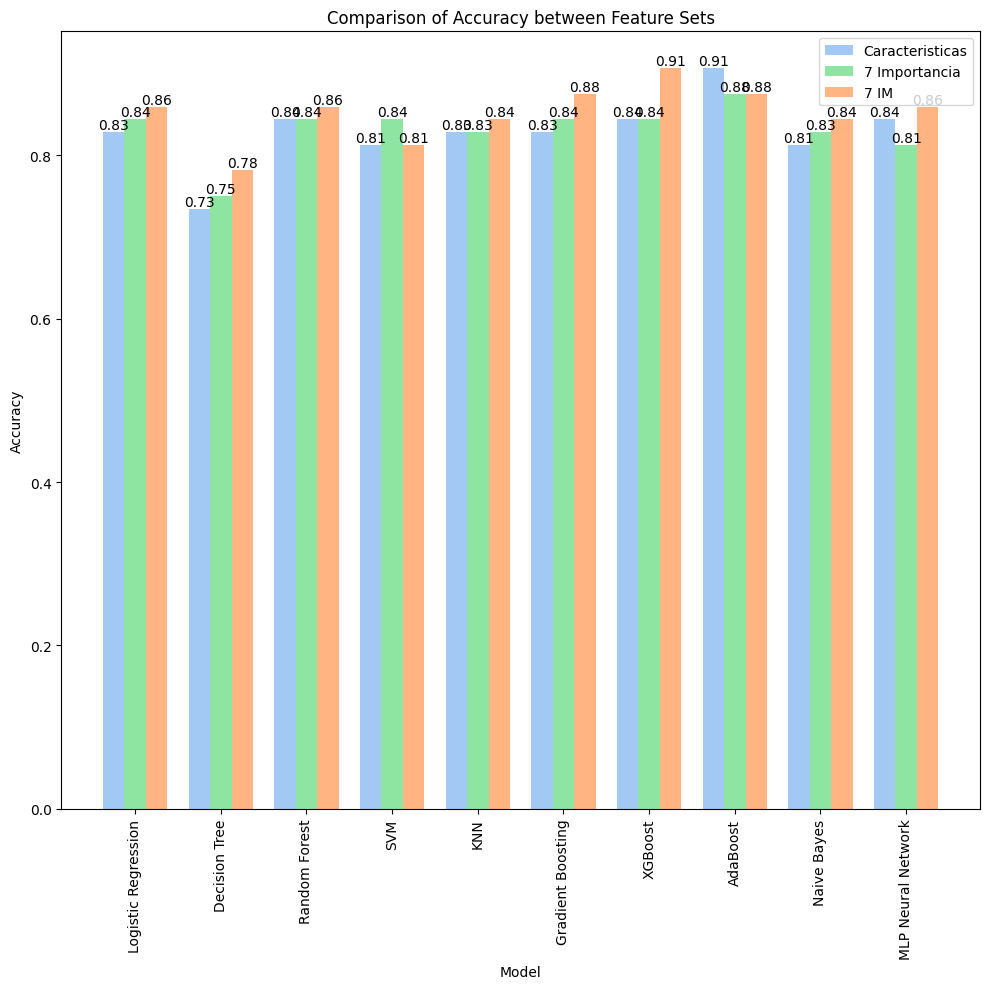

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Modelos y accuracies para tres conjuntos de características
modelos = list(accuracies[0].Model)
accuracy_set_1 = list(accuracies[0].Accuracy)
accuracy_selected = list(accuracies[2].Accuracy)
accuracy_set_3 = list(accuracies[3].Accuracy)

# Posicion y ancho de la barras
x = np.arange(len(modelos))
width = 0.25

# Crear la gráfica
fig, ax = plt.subplots(figsize=(10, 10))
color = sns.color_palette("pastel")

# Barras para Feature Set 1
bars1 = ax.bar(x - width, accuracy_set_1, width, label='Caracteristicas', color=color[0])
bars2 = ax.bar(x, accuracy_selected, width, label='7 Importancia', color=color[2])
bars3 = ax.bar(x + width, accuracy_set_3, width, label='7 IM', color=color[1])

# Etiquetas y título
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracy between Feature Sets')
ax.set_xticks(x)
ax.set_xticklabels(modelos, rotation=90)
ax.legend()

# Mostrar los valores de accuracy sobre las barras
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Mostrar la gráfica
plt.tight_layout()
plt.show()
